In [5]:
import numpy as np
from matplotlib import pyplot as plt

from warper import simulate_2d_only_memory, simulate_2d_only_memory_anharmonic_1

from multiprocessing import Pool

import os, pickle
from tqdm.notebook import tqdm

import pandas as pd

In [6]:
pool = Pool(4)

In [7]:
def get_RSH(A,B,g0,b,ka):
    o0 = np.sqrt(-A)
    mu = ka
    S = 1/g0/2/ka**2*(ka**2+o0**2+g0*ka+b**2)
    R = 1/g0/2/o0**2/ka**2 * (o0**2+ka**2)
    H = - 1/2/g0/ka**2*b
    return R,S,H, 2*(R*S+H**2)

def mean_with_err(arr, axis):
    return arr.mean(axis=axis), arr.std(axis=axis)/np.sqrt(arr.shape[axis])

In [8]:
# params - A,B,g0,b,ka

params = [
    (-1,0,1,0,1),
    (-1,0,1,1,1),
    (-1,0,1,2,1),
    (-1,0,1,3,1),
    
    (-1,0.5,1,0,1),
    (-1,0.5,1,1,1),
    (-1,0.5,1,2,1),
    (-1,0.5,1,3,1),
    
    (3,0.4,1,0,1),
    (3,0.4,1,1,1),
    (3,0.4,1,2,1),
    (3,0.4,1,3,1),

]


df = pd.DataFrame(params, columns=["A","B","g0","b","ka"])

In [9]:
def f(row):
    return pd.Series(get_RSH(row.A, row.B, row.g0, row.b, row.ka),index=("R","S","H","varL"))
df = pd.concat([df, df.apply(f, axis=1)], axis=1, sort=False)

/home/ashot/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [10]:
df

,A,B,g0,b,ka,R,S,H,varL
0,-1,0.0,1,0,1,1.0,1.5,-0.0,3.0
1,-1,0.0,1,1,1,1.0,2.0,-0.5,4.5
2,-1,0.0,1,2,1,1.0,3.5,-1.0,9.0
3,-1,0.0,1,3,1,1.0,6.0,-1.5,16.5
4,-1,0.5,1,0,1,1.0,1.5,-0.0,3.0
5,-1,0.5,1,1,1,1.0,2.0,-0.5,4.5
6,-1,0.5,1,2,1,1.0,3.5,-1.0,9.0
7,-1,0.5,1,3,1,1.0,6.0,-1.5,16.5
8,3,0.4,1,0,1,NaN,NaN,-0.0,NaN
9,3,0.4,1,1,1,NaN,NaN,-0.5,NaN


In [11]:
N=3000000
warmup=0
dt=0.001
samples=400
skip=500
runs=4
time = np.linspace(0,N//skip *dt, N//skip)

In [ ]:
results = []
for row in tqdm(df.itertuples(), total=len(df)):
    kwargs = dict(x0=np.zeros(samples),y0=np.zeros(samples),
                  vx0=np.zeros(samples),vy0=np.zeros(samples),
        N=N, samples=samples,
        dt=dt, warmup=warmup, skip=skip,
        A=row.A,B=row.B,gamma0=row.g0,b=row.b, kappa=row.ka)
    results.append(simulate_2d_only_memory_anharmonic_1(pool,runs,**kwargs))

results = np.array(results)

In [9]:
results[:,:,:,:].shape

(8, 6, 1200, 5000)

In [51]:
cov = np.einsum("iakj,ibkj->ijab", results[:,:4,:,:],results[:,:4,:,:],optimize=True)/(results.shape[2]-1)

In [52]:
cov.shape

(8, 5000, 4, 4)

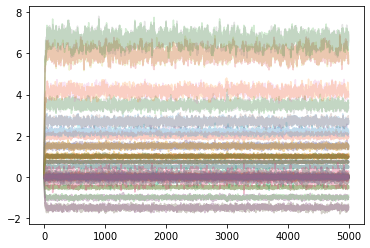

In [55]:
plt.plot(cov.transpose(1,0,2,3).reshape(-1,cov.shape[0]*16)[::], alpha=0.2);
# plt.plot(cov[5,:,1,2]);

In [56]:
stationari_treshold = 1000

In [57]:
results.shape

(8, 6, 1200, 5000)

In [84]:
Rx,Ry, Sx, Sy, _,_ = results[...,stationari_treshold:].var(axis=2).transpose(1,0,2)
Lx = results[:,0] * results[:,3]
Ly = results[:,1] * results[:,2]

Hx = Lx.mean(axis=1)
Hy = Ly.mean(axis=1)

In [86]:
df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)
df["Ry"], df["Ry_err"]= mean_with_err(Ry,axis=-1)
df["Sx"], df["Sx_err"]= mean_with_err(Sx,axis=-1)
df["Sy"], df["Sy_err"]= mean_with_err(Sy,axis=-1)
df["Hx"], df["Hx_err"]= mean_with_err(Hx,axis=-1)
df["Hy"], df["Hy_err"]= mean_with_err(Hy,axis=-1)

# df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)


In [90]:
df[sorted(df.columns)].round(4)

,A,B,H,Hx,Hx_err,Hy,Hy_err,R,Rx,Rx_err,...,Ry_err,S,Sx,Sx_err,Sy,Sy_err,b,g0,ka,varL
0,-1,0.0,-0.0,0.0013,0.0005,-0.0014,0.0005,1.0,0.9985,0.0006,...,0.0006,1.5,1.4979,0.0010,1.4984,0.0010,0,1,1,3.0
1,-1,0.0,-0.5,-0.4985,0.0006,0.4984,0.0006,1.0,0.9980,0.0006,...,0.0006,2.0,1.9956,0.0013,1.9959,0.0013,1,1,1,4.5
2,-1,0.0,-1.0,-0.9981,0.0009,0.9985,0.0009,1.0,0.9986,0.0006,...,0.0006,3.5,3.4915,0.0022,3.4903,0.0022,2,1,1,9.0
3,-1,0.0,-1.5,-1.4961,0.0014,1.4961,0.0013,1.0,0.9967,0.0007,...,0.0007,6.0,5.9906,0.0039,5.9936,0.0040,3,1,1,16.5
4,-1,0.5,-0.0,0.0022,0.0005,-0.0023,0.0005,1.0,0.7291,0.0004,...,0.0004,1.5,2.1897,0.0015,2.1815,0.0015,0,1,1,3.0
5,-1,0.5,-0.5,-0.4929,0.0006,0.4930,0.0006,1.0,0.7276,0.0004,...,0.0004,2.0,2.6786,0.0019,2.6761,0.0019,1,1,1,4.5
6,-1,0.5,-1.0,-0.9883,0.0009,0.9875,0.0009,1.0,0.7256,0.0004,...,0.0004,3.5,4.1557,0.0028,4.1624,0.0028,2,1,1,9.0
7,-1,0.5,-1.5,-1.4879,0.0012,1.4882,0.0013,1.0,0.7245,0.0004,...,0.0004,6.0,6.6574,0.0043,6.6543,0.0044,3,1,1,16.5


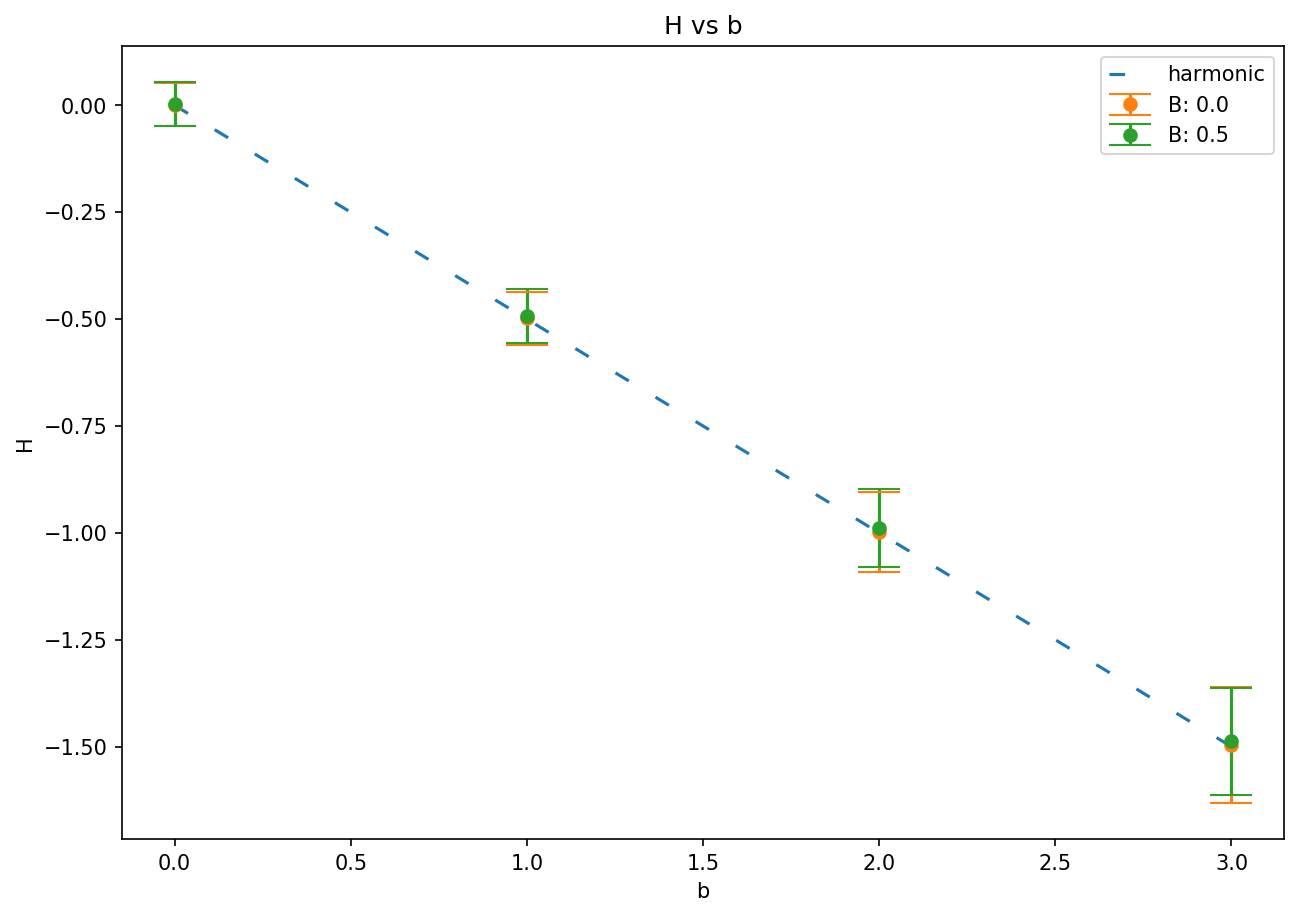

In [140]:
gb=df.groupby("B")

plt.figure(figsize=(10,7), dpi=150)
plt.title("H vs b")
plt.xlabel("b");plt.ylabel("H")
plt.plot(gb.get_group(0).b, gb.get_group(0).H, ls=(0, (5, 10)), label="harmonic")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Hx, yerr=gp.Hx_err*100, capsize=10, marker="o", ls="none", label=f"B: {key}")
plt.legend()

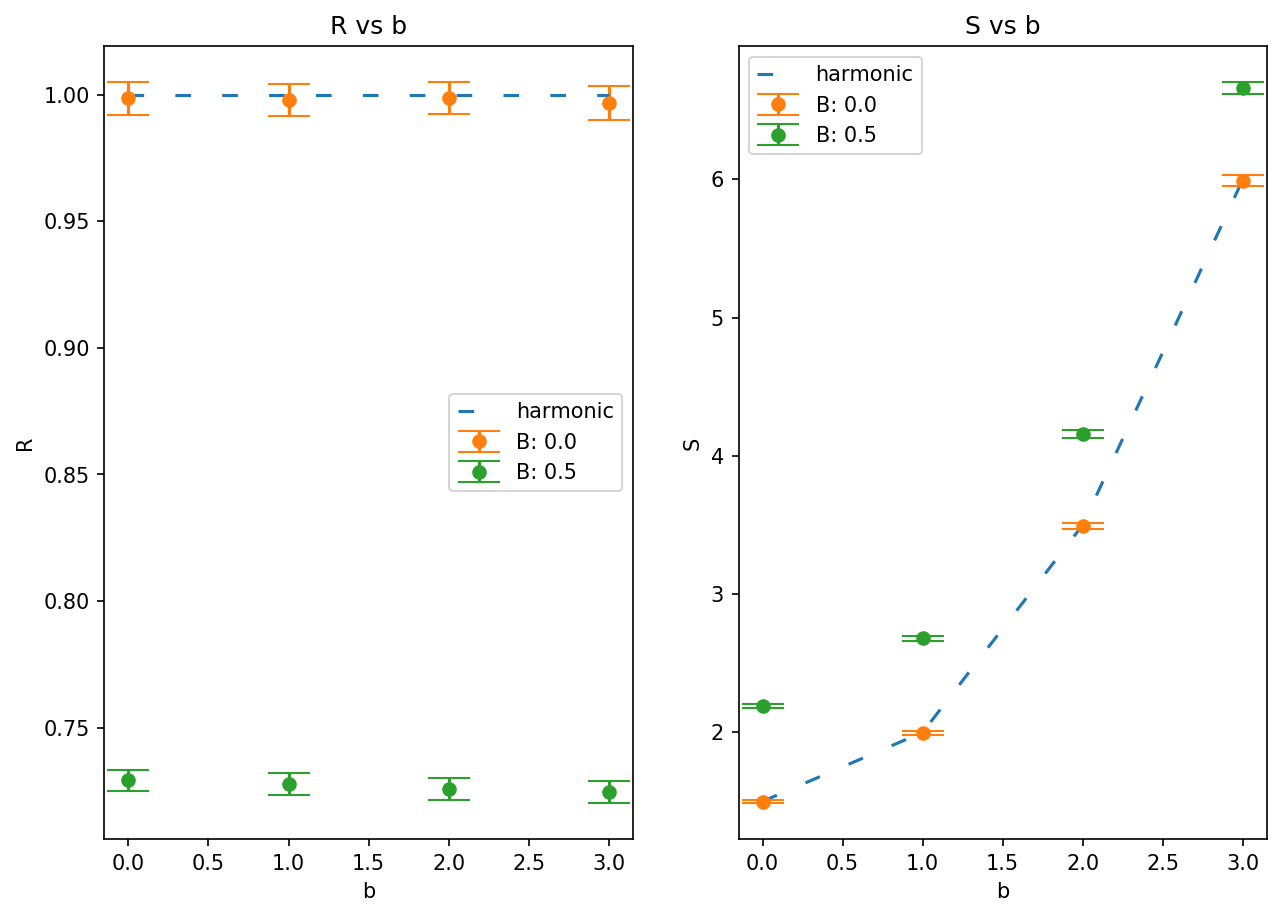

In [145]:
gb=df.groupby("B")

plt.figure(figsize=(10,7), dpi=150)
plt.subplot(121)
plt.title("R vs b")
plt.xlabel("b");plt.ylabel("R")
plt.plot(gb.get_group(0).b, gb.get_group(0).R, ls=(0, (5, 10)), label="harmonic")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Rx, yerr=gp.Rx_err*10, capsize=10, marker="o", ls="none", label=f"B: {key}")
plt.legend()

plt.subplot(122)
plt.title("S vs b")
plt.xlabel("b");plt.ylabel("S")
plt.plot(gb.get_group(0).b, gb.get_group(0).S, ls=(0, (5, 10)), label="harmonic")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Sx, yerr=gp.Sx_err*10, capsize=10, marker="o", ls="none", label=f"B: {key}")
plt.legend()

In [102]:
gb.groups

{0.0: Int64Index([0, 1, 2, 3], dtype='int64'),
 0.5: Int64Index([4, 5, 6, 7], dtype='int64')}

In [98]:
dir(gb)

['A',
 'B',
 'H',
 'Hx',
 'Hx_err',
 'Hy',
 'Hy_err',
 'R',
 'Rx',
 'Rx_err',
 'Ry',
 'Ry_err',
 'S',
 'Sx',
 'Sx_err',
 'Sy',
 'Sy_err',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_accessors',
 '_add_numeric_operations',
 '_agg_examples_doc',
 '_agg_see_also_doc',
 '_aggregate',
 '_aggregate_generic',
 '_aggregate_item_by_item',
 '_aggregate_multiple_funcs',
 '_apply_filter',
 '_apply_to_column_groupbys',
 '_apply_whitelist',
 '_assure_grouper',
 '_block_agg_axis',
 '_bool_agg',
 '_builtin_table',
 '_choose_path',
 '_concat_objects',
 '_constructor',
 '_cumcount_array',
 '_cyt

In [14]:
R_sample = results.var(axis=2)[:,0] 
S_sample = results.var(axis=2)[:,2]

In [18]:
L = (results[:,0] * results[:,3] - results[:,1] * results[:,2])
H_sample = L.mean(axis=1)/2

In [20]:
H_sample.shape

(8, 5000)

In [23]:
H_sample[:,-3000:].mean(axis=1)

array([ 1.36738691e-03, -4.97941103e-01, -9.98061171e-01, -1.49994406e+00,
        1.76045506e-03, -4.93537808e-01, -9.87554594e-01, -1.48736006e+00])

In [28]:
np.sqrt(H_sample[:,-3000:].var(axis=1)/3000)

array([0.00046711, 0.00053121, 0.00076802, 0.00109853, 0.00046564,
       0.00054357, 0.00074373, 0.00096304])

In [24]:
H

(-0.0, -0.5, -1.0, -1.5, -0.0, -0.5, -1.0, -1.5)

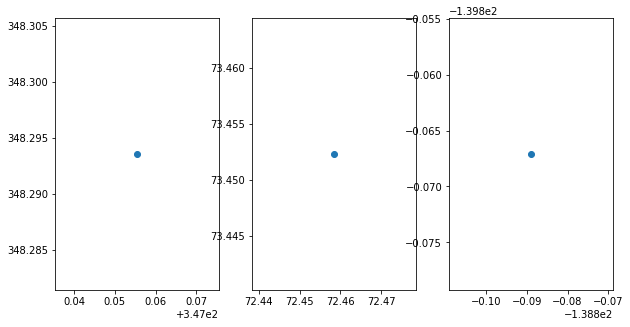

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.scatter(S, S_sample[..., -1])
plt.subplot(132)
plt.scatter(R, R_sample[..., -1])
plt.subplot(133)
plt.scatter(H, H_sample[..., -1])

In [17]:
results.shape

(1, 6, 800, 5000)

In [18]:
L.shape

(1, 800, 5000)

In [33]:
# T = results[:,2,:,:]
T = L/2
hlines = H

In [35]:
T.shape[0]

1

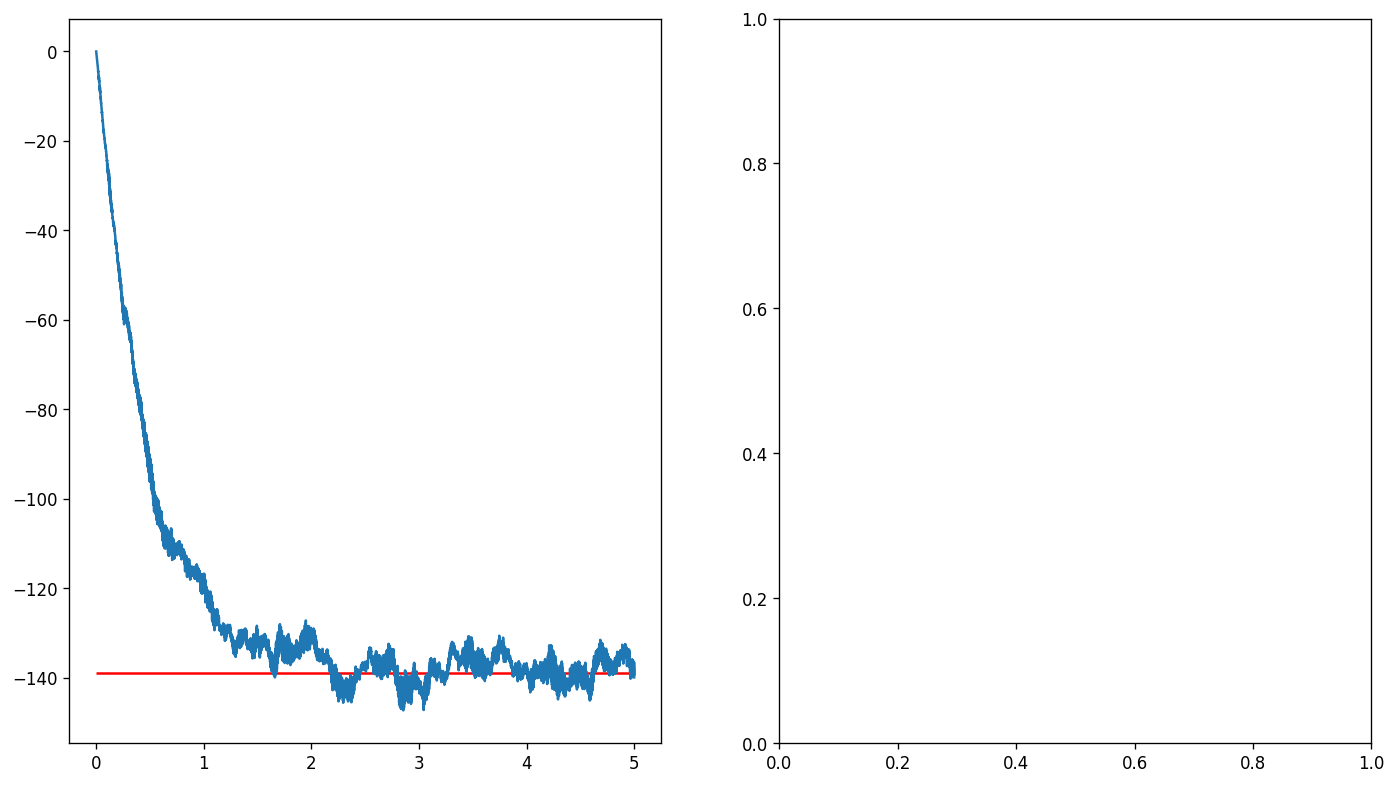

In [36]:
fig, axs = plt.subplots(1+T.shape[0]//2,2,figsize=(14,8),dpi=120)
for ax, xi,h in zip(axs.flatten(),T[:,:,:], hlines):
    ax.plot(time, xi.mean(axis=0))
    ax.hlines(y=h, xmin=0, xmax=max(time), colors="r")
# plt.show()

In [20]:
L.shape

(2, 800, 5000)

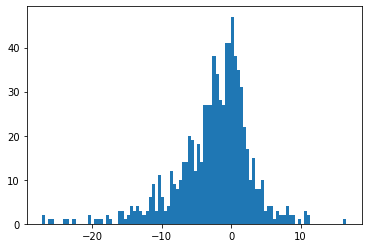

In [21]:
plt.hist(L[0,:,-1], bins=100);

In [22]:
L[1,:,-1].mean()

-275.58011008311655

In [23]:
sorted(L[1,:,-1])[1600]

IndexError: list index out of range

In [ ]:
L.shape

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(L[1,2,3000:])